In [1]:
"""
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install nltk
"""

import numpy as np
import pandas as pd
import re
re.__version__

import html
import unicodedata

import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages

In [2]:
elec_tweets=pd.read_csv('US_Elections_2020.csv')
elec_tweets.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


In [3]:
#remove html tags and attributes
def remove_tag(text):
    tag=re.compile(r'<[^>]+>')
    return tag.sub(' ',text)
   

#replace html characters with ascii code equivalent
def html_convert(text):    
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')
    return text

#remove URLs and convert all characters into lowercase
def url_lower(s):
    s=re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', s)
    s=s.lower()
    return s

#remove stopwords, and lemmatize words
with open("stop_words.txt") as f:      
 stop_word = f.read().splitlines()    # Here I edited the stop_words.txt file, words like "don't",'no',"shouldn't","neither" were not considered as stop words.
pd.DataFrame(stop_word).to_csv("stop_words.txt",index=False)    #save the text file to the directory using this code

def stopword(text):
    
    doc=nlp(text,disable=['ner','parser'])              
    lemmas = [token.lemma_ for token in doc]           
    a_lemmas=[lemma for lemma in lemmas if lemma not in stop_word and lemma !='-pron-' and lemma !='-PRON-']     
    return ' '.join(a_lemmas)

#remove some punctuations
def pun_remove(text):
    punctuations='''!()[]{};:"/\,@.+-?#$%^*_~'''    
    for char in text:
       if (char in punctuations):
          text=text.replace(char," ")
    return text

# remove retweet
def retweet(text):
    text = re.sub(r'\brt\b', '', text)
    return text

#remove emoji
def remove_emoji(text):
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    return text

# replace multiple spaces with a single space
def space(text):    
    text = re.sub(r'\s+', ' ', text)
    return text

#remove character \\n \\n\\n and b',b" characters
def remove_b_n(text):
    text=text.replace("\\n\\n"," ")
    text=text.replace("\\n"," ")
    text=text.replace("\n"," ")
    text=text.replace("b'"," ")
    text=text.replace('b"'," ")
    return text


In [4]:
elec_tweets['text']=elec_tweets['text'].apply(remove_b_n)

In [5]:
elec_tweets['text']=elec_tweets['text'].apply(remove_tag)
elec_tweets['text']=elec_tweets['text'].apply(html_convert)
elec_tweets['text']=elec_tweets['text'].apply(url_lower)
elec_tweets['text']=elec_tweets['text'].apply(retweet)
elec_tweets['text']=elec_tweets['text'].apply(remove_emoji)

In [6]:
elec_tweets['text']=elec_tweets['text'].apply(pun_remove)

In [7]:
elec_tweets['text']=elec_tweets['text'].apply(stopword)

In [8]:
elec_tweets['text']=elec_tweets['text'].apply(space)

In [9]:
elec_tweets.head()    

,text,sentiment,negative_reason
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19
1,suec00k lord sumption launch recovery initiat...,0,others
2,walidphare uber time biden advisor pressure b...,0,covid19
3,107 second american die trumpvirus donaldtrum...,1,NaN
4,thewebbix democrats embrace diversityandinclu...,1,NaN


In [10]:
sentiment_og=pd.read_csv('sentiment_analysis.csv')
#sentiment_og = sentiment_og.drop(['ID'],axis=1)
sentiment_og.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [11]:
sentiment= sentiment_og.groupby('label').apply(lambda x: x.sample(frac=0.2))
sentiment

ID                                               text  \
label                                                                           
0     271463  7.980660e+17  #Sport - Jose Mourinho looks sour and glum... ...   
      278426  7.982830e+17  @spencerlist lowkey made me ruin my thread but...   
      318654  7.996840e+17  mashable : Trump writes deeply misleading twee...   
      470642  7.690170e+17  RT @albacamilo1: YoHis palms are sweaty, knees...   
      45458   7.686960e+17  RT @cnnbrk: 1 person killed, 21 hurt in attack...   
...                    ...                                                ...   
1     22457   7.683700e+17  RT @bassam_jaleel: wonderful opportunity to wi...   
      95912   7.694320e+17  RT @milanicosmetics: RT if you are in love wit...   
      267741  7.978030e+17  These Dhb Turbo Goggles are amazing for only £...   
      479170  7.693860e+17  i love my baby @miafunderburkk i know i was wi...   
      159818  7.827670e+17  #YourTeacherX Cam2Cam with her https://t.co/0a...   

              label  
label                
0     271463      0  
      278426      0  
      318654      0  
      470642      0  
      45458       0  
...             ...  
1     22457       1  
      95912       1  
      267741      1  
      479170      1  
      159818      1  

[110078 rows x 3 columns]

In [12]:
#shuffle data

sentiment=sentiment.sample(frac=1).reset_index(drop=True)
sentiment

,ID,text,label
0,7.687830e+17,RT @SwedishPM: Just had the pleasure to welcom...,1
1,7.979860e+17,❝Harry Styles Lock-screen❞RT if you saved it. ...,1
2,7.983480e+17,World`s Most Healthiest Vitality Drink: Boost ...,1
3,7.695310e+17,RT @TvlertheCreator: when you're on your 295th...,0
4,8.032510e+17,can't wait! RT @KentuckyMBB: It's game day in ...,1
...,...,...,...
110073,7.683160e+17,"RT @filmtraiIers: ""I am both happy &amp; sad a...",1
110074,7.981120e+17,"""The best way to listen is with your mouth shu...",1
110075,7.960660e+17,People being around factories are NOT safe due...,0
110076,8.004610e+17,2 of the Best Tools to Manage Social Media. Co...,1


In [13]:
#Since the difine functions for cleaning can also be applied into this data set, we just apply the functions.

sentiment['text']=sentiment['text'].apply(remove_b_n)

In [14]:
sentiment['text']=sentiment['text'].apply(remove_tag)
sentiment['text']=sentiment['text'].apply(html_convert)
sentiment['text']=sentiment['text'].apply(url_lower)
sentiment['text']=sentiment['text'].apply(retweet)
sentiment['text']=sentiment['text'].apply(remove_emoji)

In [15]:
sentiment['text']=sentiment['text'].apply(pun_remove)

In [16]:
sentiment['text']=sentiment['text'].apply(stopword)

In [17]:
sentiment['text']=sentiment['text'].apply(space)

In [18]:
sentiment.head()

,ID,text,label
0,7.687830e+17,swedishpm pleasure vp joe biden sweden,1
1,7.979860e+17,harry style lock screenrt save honest ariasone...,1
2,7.983480e+17,world`s healthy vitality drink boost health & ...,1
3,7.695310e+17,tvlerthecreator 295th selfie attempt & refuse...,0
4,8.032510e+17,n't wait kentuckymbb game day paradise,1


In [19]:
#determine the political party

republican=['trump','donald','borisjohnson','moscowmitch','conservative','republican','votered','redwave','4moreyears']
democratic=['biden','joe','kamalaharris','democrat','voteblue','bluewave','bidenharris','blm']
text=elec_tweets['text']
elec_tweets['Party']='N'
count_both=0
count_demo=0
count_repu=0
count_others=0
for i in range(len(text)):
  if (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('|'.join(democratic))[i]==True): 
        elec_tweets['Party'][i]='Both'
        count_both+=1
  elif (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('&'.join(democratic))[i]==False):     #'Republican Party' means tweets only relevant to Republican Party
        elec_tweets['Party'][i]='Republican Party'
        count_repu+=1
  elif (text.str.contains('&'.join(republican))[i]==False) & (text.str.contains('|'.join(democratic))[i]==True):     #'Democratic Party' means tweets only relevant to Democratic Party
        elec_tweets['Party'][i]='Democratic Party'                                  
        count_demo+=1
  else:
       elec_tweets['Party'][i]='Others'
       count_others+=1
    
elec_tweets['Party']

0       Democratic Party
1                 Others
2       Democratic Party
3                   Both
4       Democratic Party
              ...       
2547              Others
2548    Democratic Party
2549    Republican Party
2550    Democratic Party
2551              Others
Name: Party, Length: 2552, dtype: object

In [20]:
elec_tweets[elec_tweets['Party']=='Democratic Party']

,text,sentiment,negative_reason,Party
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,Democratic Party
2,walidphare uber time biden advisor pressure b...,0,covid19,Democratic Party
4,thewebbix democrats embrace diversityandinclu...,1,NaN,Democratic Party
10,breakingnew october catsoftwitter dogsoftwitt...,0,corruption,Democratic Party
15,watch happen 4 57 dethippiechick 's broadcast...,1,NaN,Democratic Party
...,...,...,...,...
2524,I trunalimunumaprzure bidenharris2020 ',1,NaN,Democratic Party
2525,azynnn tear voteblue ',0,others,Democratic Party
2531,foxnew broadcast joebiden rally st paul cnn m...,1,NaN,Democratic Party
2548,nowthisnew deliver today montgomery county pa...,1,NaN,Democratic Party


In [21]:
elec_tweets[elec_tweets['Party']=='Republican Party']

,text,sentiment,negative_reason,Party
5,accelerate & rise american kill trumpvirus,0,discrimination,Republican Party
6,realdonaldtrump 961 dead american day 240 tim...,0,discrimination,Republican Party
8,charliekirk11 reason realdonaldtrump 3 rally ...,0,corruption,Republican Party
11,realdonaldtrump ur campaign pay people rig me...,0,crime,Republican Party
13,realdonaldtrump maga disgusting sunday school ',0,discrimination,Republican Party
...,...,...,...,...
2528,I poll trump win landslide victory paint map ...,1,NaN,Republican Party
2534,realdonaldtrump kill american dream covid cas...,0,corruption,Republican Party
2539,trump force hold rally front small socially d...,0,discrimination,Republican Party
2540,trumpsdeadlysin unlimited covid 30 000 lie fa...,0,others,Republican Party


In [22]:
elec_tweets[elec_tweets['Party']=='Both']

,text,sentiment,negative_reason,Party
3,107 second american die trumpvirus donaldtrum...,1,NaN,Both
9,joebarri concern hunterbiden trump ass kisser...,0,covid19,Both
16,joebiden call trump supporter ugly shame day ...,0,corruption,Both
18,realdonaldtrump I will glad listen ass voice ...,0,covid19,Both
62,rwtrollpatrol joebiden watch great film meida...,1,NaN,Both
...,...,...,...,...
2494,mike pence realdonaldtrump america n't afford...,0,discrimination,Both
2502,kokomothegreat realdonaldtrump healthcare pro...,0,crime,Both
2526,biden lead trump poll exist pollster force tr...,0,discrimination,Both
2532,iaco poll wishful thinking democrat fake news...,0,corruption,Both


In [23]:
# count of different parties 

print('The number of the tweets that identify only Democratic Party is: ', count_demo)
print('The number of the tweets that identify only Republican Party is: ', count_repu)
print('The number of the tweets that identify Both Parties is: ', count_both)
print('The number of the tweets that identify others is: ', count_others)

The number of the tweets that identify only Democratic Party is:  565
The number of the tweets that identify only Republican Party is:  654
The number of the tweets that identify Both Parties is:  282
The number of the tweets that identify others is:  1051


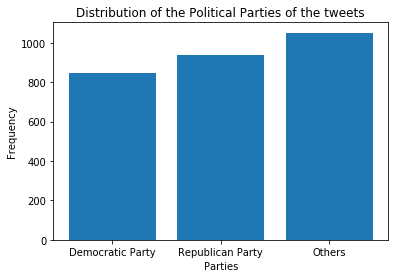

In [24]:
### frequency distribution bar plot

party=['Democratic Party','Republican Party','Others']
freq=[count_demo+count_both,count_repu+count_both,count_others]  #I added "both" to the two groups "Democratic Party" and "Republican Party" here to see the general frequency distribution
plt.bar(party, freq)
plt.title("Distribution of the Political Parties of the tweets")
plt.xlabel("Parties")
plt.ylabel("Frequency")

plt.show()

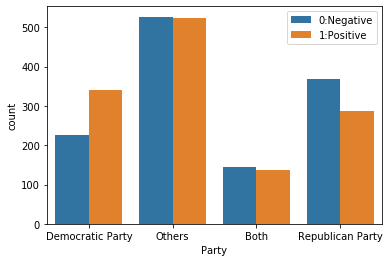

In [25]:
ax = sns.countplot(x='Party', hue='sentiment', data=elec_tweets)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['0:Negative','1:Positive'], bbox_to_anchor=(1,1))
plt.show();

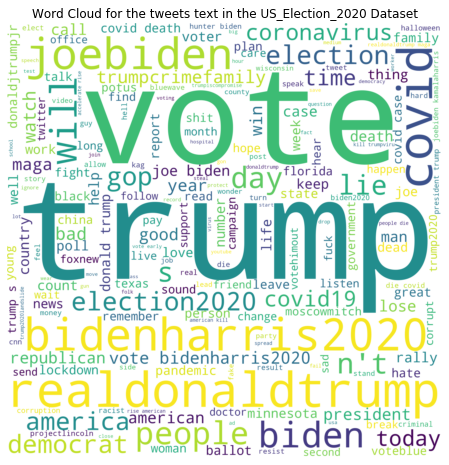

In [26]:
# wordcloud for all texts of the tweets(text cleaned already)
words=''
for val in elec_tweets['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the US_Election_2020 Dataset')
plt.show()

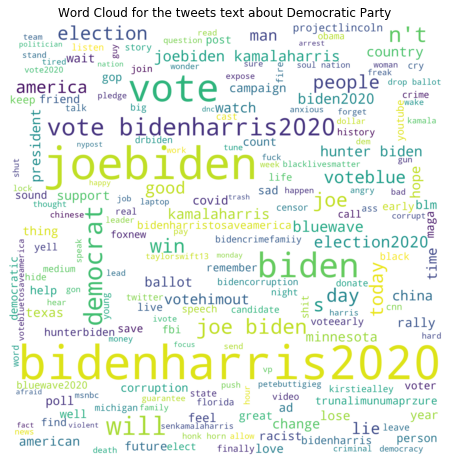

In [27]:
#wordcloud for tweets only about Democratic Party

words=''
for val in elec_tweets['text'][elec_tweets['Party']=='Democratic Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Democratic Party')
plt.show()

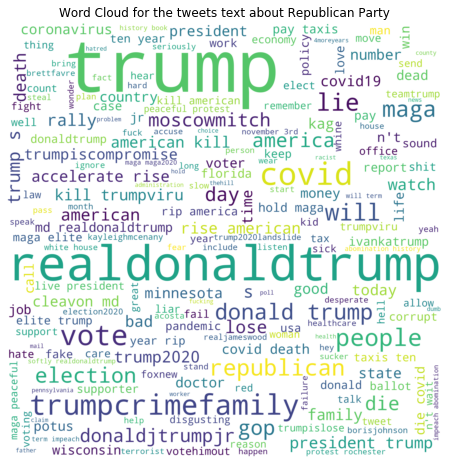

In [28]:
#wordcloud for tweets only about Republican Party

words=''
for val in elec_tweets['text'][elec_tweets['Party']=='Republican Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Republican Party')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000269D7F09B70>],
      dtype=object)

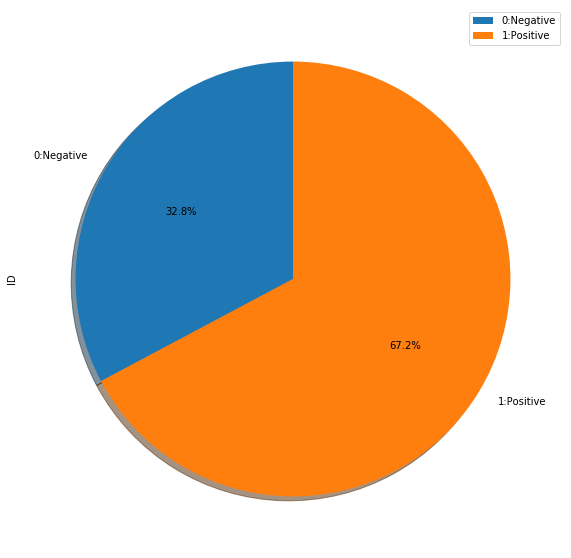

In [30]:
labels='0:Negative','1:Positive'
sentiment.groupby(['label']).sum().plot(kind='pie', subplots=True, labels=labels,shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%')

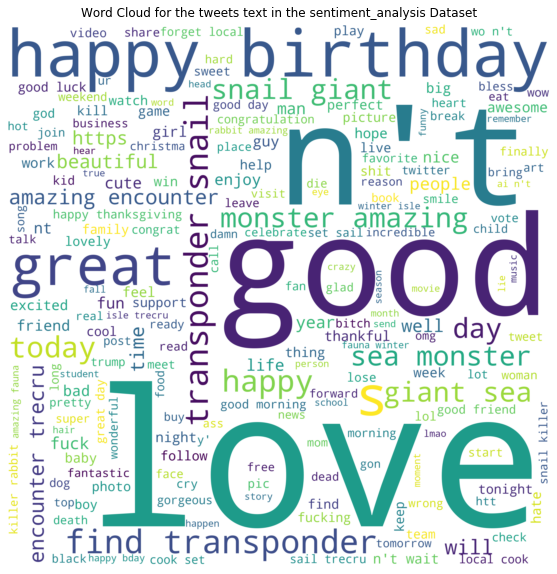

In [31]:
words=''
for val in sentiment['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (10, 10))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the sentiment_analysis Dataset')
plt.show()

## BoW and TF-IDF Vectors

In [32]:
vector1=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vector_bow=vector1.transform(sentiment.text)
vector_bow

<110078x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 570714 stored elements in Compressed Sparse Row format>

In [33]:
vector2=TfidfVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vector_tfidf=vector2.transform(sentiment.text)
vector_tfidf

<110078x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 570714 stored elements in Compressed Sparse Row format>

In [34]:
y1=sentiment.label
X1=vector_bow
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.3,random_state=0,stratify=sentiment['label'])

In [35]:
y2=sentiment.label
X2=vector_tfidf
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.3,random_state=0,stratify=sentiment['label'])

### Classifiers for BoW vector

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train1, y_train1)
y_pred2_train=knn.predict(X_train1)
y_pred2_test=knn.predict(X_test1)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train1,y_pred2_train)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test1,y_pred2_test)*100,2)))

Training accuracy for k-NN is:91.62%
Test accuracy for k-NN is: 87.88%


In [37]:
mnb = MultinomialNB()
mnb.fit(X_train1,y_train1)
y_pred3_train=mnb.predict(X_train1)
y_pred3_test=mnb.predict(X_test1)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train1,y_pred3_train)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test1,y_pred3_test)*100,2)))

Training accuracy for Naive Bayes is:93.71%
Test accuracy for Naive Bayes is: 92.98%


### Classifiers for TF-IDF vector

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train2)
y_pred2_train_=knn.predict(X_train2)
y_pred2_test_=knn.predict(X_test2)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train2,y_pred2_train_)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test2,y_pred2_test_)*100,2)))

Training accuracy for k-NN is:86.15%
Test accuracy for k-NN is: 78.3%


In [39]:
mnb = MultinomialNB()
mnb.fit(X_train2,y_train2)
y_pred3_train_=mnb.predict(X_train2)
y_pred3_test_=mnb.predict(X_test2)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train2,y_pred3_train_)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test2,y_pred3_test_)*100,2)))

Training accuracy for Naive Bayes is:92.79%
Test accuracy for Naive Bayes is: 91.81%


## Evaluating the classifier on the US Election dataset

In [40]:
#CountVectorize sentiment in the tweets

vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(elec_tweets.text)
vect_=vect.transform(elec_tweets.text)

#using the MNB model above to evaluate the US Election Dataset

y=elec_tweets.sentiment
X=vect_
mnb=MultinomialNB().fit(X,y)
y_predicted=mnb.predict(X)

print('Accuracy using a Multinomial Naive Bayes Classifier on 2020 US election data is: {}%'.format(round(accuracy_score(y,y_predicted)*100,2)))

Accuracy using a Multinomial Naive Bayes Classifier on 2020 US election data is: 94.32%
